## Blender+python based tissue cartography software stack

Tissue cartography (TC) is a tool for analyzing 3d biological image data by taking advantage of the laminar, sheet-like organization of many biological tissues. Tissue cartography extracts a surface of interest (SOI) from the volumetric image data, for example the the tube-like structure of the developing fly gut, and cartographically projects it into a 2d plane (see figure below, from [Mitchell & Cislo 2023](https://doi.org/10.1038/s41592-023-02081-w)). This is extremely helpful for both data visualization and data analysis, for example cell tracking.

<div>
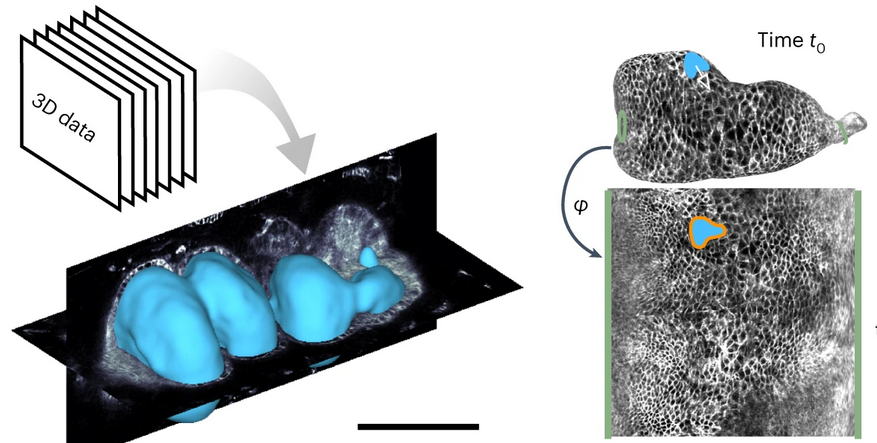
</div>

Tissue cartography was pioneered by [Heemskerk & Streichan 2015](https://doi.org/10.1038/nmeth.3648) (ImSAnE software package), and more recent refined by [Mitchell & Cislo 2023](https://doi.org/10.1038/s41592-023-02081-w) (TubULAR software package). [Herbert et al. 2021](https://doi.org/10.1186/s12915-021-01037-w) (LocalZProjector software package) developed a tissue cartography toolbox for the special case where the SOI can be parametrized by a height function above a fixed $x-y$ plane.

The existing software implementations of TC are either limited to special cases (LocalZProjector) or difficult to use for non-experts (ImSAnE) - see paragraph below. In this document, I outline a proposal for a TC pipeline that overcomes these limitations by taking advantage of high quality software developed for 3d animation.

### Tissue cartography workflow

The TC workflow begins with a volumetric recording, for example a $z$-stack recorded on a confocal microscope. We consider first the case of a single recording.

1. **Segmentation**: volumetric image $\mapsto$ 3d segmentation. From the volumetric image - a `.tif` file , the user creates a 3d segmentation, also a `.tif` file with values from 0-1. This segmentation divides the image into "inside" and "outside", and the SOI is defined as the boundary. 
    - Alternatively, if the surface is not closed or it is easier to obtain a segmentation of the surface rather than the solid body of which is is the boundary, the user should be able to provide a segmentation of the boundary only, i.e. where values of 1 correspond to pixels on the boundary.
    
2. **Meshing**: 3d segmentation $\mapsto$ triangular mesh. A triangular mesh of the segmentation boundary is computed.
    - In certain cases, it might be necessary to pass by the intermediate step of **Surface detection**: 3d segmentation $\mapsto$ point cloud $\mapsto$ mesh. 


3. **UV mapping**: Triangular mesh $\mapsto$ cartographic plane. User choses one or multiple maps from the triangular mesh to a cartographic plane (parametrized by coordinates $u, v$, to distinguish from the $x,y,z$ 3d coordinates).

4. **Projection**: volumetric image + triangular mesh + UV map $\mapsto$ projected image. The volumetric image data is interpolated onto the UV cartographic plane using the 3d positions from the triangular mesh, creating a 2d projection of the 3d image data ("pullback").
    - **Multi layers**: to capture the whole thickness of a tissue sheet, one typically creates multiple projections using a version of the triangular mesh that is shifted along the local normal direction "inwards" and "outwards" (figure from [Heemskerk & Streichan 2015](https://doi.org/10.1038/nmeth.3648)): 
    <div>
    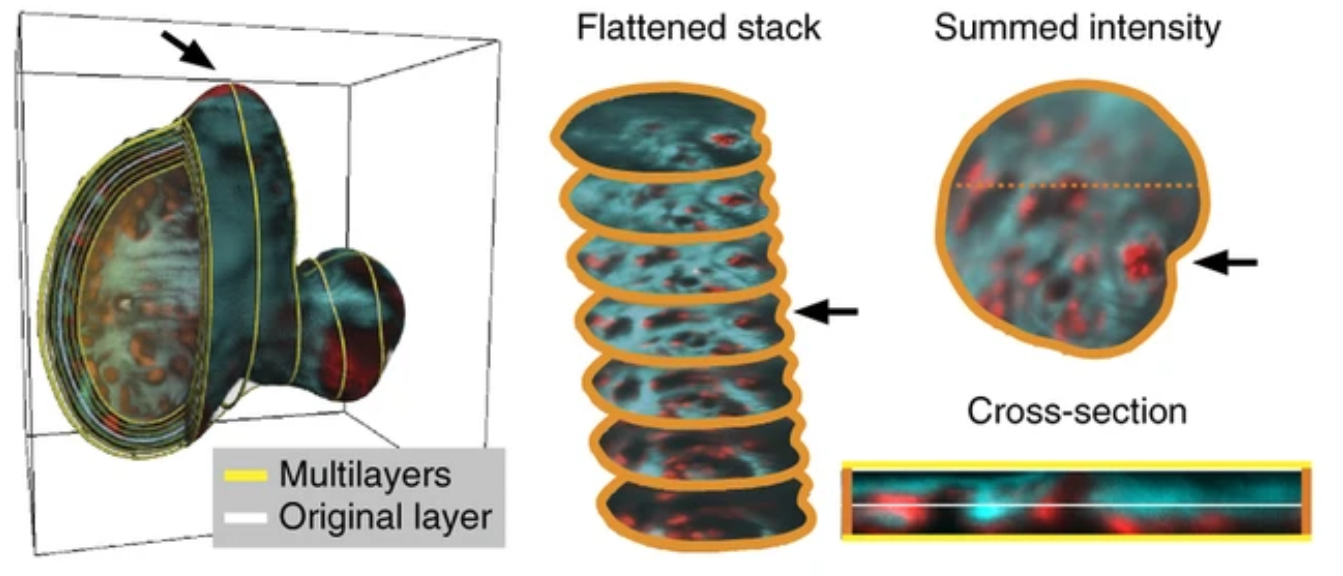
</div>




### Desiderata

Ideally, a TC toolbox should fulfill the following demands:

1. **Modularity**: the different steps in the workflow should be decoupled from one another as much as possible, and complete information about intermediate results should be saved in standard file formats (e.g. `.tiff` images, `.ply` meshes)
 
2. **Transparency**: the underlying data (e.g. surface coordinates) should be easily accessible and modifiable and not hidden behind abstractions, to allow "hacking" the pipeline for particular use cases.

3. **No reinventing the wheel**: use existing open source software with large user bases, good documentation, and continuing development as much as possible.

4. **Graphical interface**:  all data should be visualizable and modifiable using a graphical interface (e.g. to fix mesh errors). Cartographic projections should also be chosen via a graphical interface (e.g. around which point the projection is centered).

5. **Focus**: Provide a workflow for TC without bundling it together with any downstream analysis tools. Avoid special cases - the workflow should proceed in the same way for any dataset.

### Problems of existing solutions

**LocalZProjector** (and many other, similar tools) can only deal surfaces that can be described by a height function over a fixed $x-y$ plane. Closed surface, or surfaces with overhang, cannot be dealt with. 

**Imaris** and other commercial solutions are often extremely expensive and impossible to modify by the end user, leading to poor performance.

**ImSAnE** can perform all desired tasks and is in principle open source. However, it can be difficult to use, for the following reasons:
    
1. **Abstraction** - use of object oriented programming that make the underlying data (segmentations, point clouds) difficult to access and debug.
2. **Custom code** - custom code without extensive documentation, no large development community. This leads to a lack of resources (like tutorials), bug fixes, and extensions.
3. **No graphical user interface** - no graphical interface for choosing projections 

The lack of GUI and use of specialized, custom code lead to workflows that work well on the dataset they were developed for, but are difficult to adapt to new data.

### Design principles

We will rely on the following principles to overcome these problems:

1. **[Blender](https://www.blender.org/) for UV mapping and visualization** - blender is a widely used, open source program for 3D creation and contains advanced tools for mesh editing, UV mapping, and 3D visualization within a well-documented GUI.
2. **File-based encapsulation** - ensure that each step in the TC pipeline terminates in a single data file (e.g. a `.obj` mesh, a `.tif` 3d segmentation), with all subsequent steps only depending on that data file.
3. **Minimal, procedural python code** - no classes, minimal abstraction - only a set of simple, well documented functions.
4. **Jupyter notebooks** - each project starts from a "template" jupyter notebook combining workflow instruction, space for notes/screenshots, and allowing to execute the necessary python code with immediate hackability if modifying the workflow is necessary.

## Software stack

### Required

- Python, with the following libraries
    - [jupyter](https://jupyter.org/)
    - [Numpy](https://numpy.org/) / [Matplotlib](https://matplotlib.org/) / [Scipy](https://scipy.org/)
    - [skimage](https://scikit-image.org) various image processing tools.
    - [h5py](https://www.h5py.org/)  for reading/writing of `.h5` files.
    - [tifffile](https://github.com/cgohlke/tifffile/) for reading/writing of `.tif` files, including metadata.
    - [PyMCubes](https://github.com/pmneila/PyMCubes) Marching cubes.
    - [PyMeshLab](https://pymeshlab.readthedocs.io/en/latest/index.html) Python interface to MeshLab.
- [Ilastik](https://www.ilastik.org/) Image classification and segmentation,
- [Meshlab](https://www.meshlab.net/) GUI and python library with advanced surface reconstruction tools (required for some workflows).
- [Blender](https://www.blender.org/) Mesh editing and UV mapping.

### Optional

- Python libraries:
    - [Morphsnakes](https://github.com/pmneila/morphsnakes) "Inflating balloon" segmentation 
    - [trimesh](https://trimesh.org/) for working with triangular meshes
- Blender plugins:
    - [MicroscopyNodes](https://github.com/oanegros/MicroscopyNodes) for rendering volumetric `.tif` files in blender
    - [Uvsquares](https://github.com/Radivarig/UvSquares) For UV maps with uniform distortion

## Workflow

We begin by creating a folder for the project and placing the relevant data into it.  We open a new blender project and start a jupyter notebook server. Depending on the data, we copy a suitable template jupyter notebook into the folder, which will serve to execute the required python code and store any notes about the project.

### Segmentation

To create a segmentation, we first downsample the data to reduce computational overhead. Next, we can use any of the following tools to create a 3d segmentation:

1. [Ilastik](https://www.ilastik.org/)
2. [Morphsnakes](https://github.com/pmneila/morphsnakes)
3. Custom python code

We assume that our SOI is a **closed/watertight surface** the segmentation is a **level set segmentation** distinguishing "inside" and "outside" (this includes the case where the SOI ends at the 3d image boundary).

**Output**: 3d segmentation as `.tif` file

### Meshing

When the surface is defined as a segmentation level set, robust algorithms exist to compute the corresponding mesh, namely [marching cubes](https://en.wikipedia.org/wiki/Marching_cubes) and [many other](https://swiftcoder.wordpress.com/planets/isosurface-extraction/). 

1. [PyMCubes](https://github.com/pmneila/PyMCubes) Minimalist python library for marching cubes.
2. [MeshLab](https://www.meshlab.net/) GUI and python library, contains marching cubes and many other tools for surface reconstruction

#### Alternate workflow: segmentation and meshing for open surfaces

If we have an  **open surface**, different possibilities exist:
1. Create a 3d segmentation and use isosurface meshing as for a watertight surface. This will result is a closed mesh with "two sides", one of which can be removed in postprocessing
2. Create a 3d segmentation, and skeletonize it to extract a point cloud. From a point cloud, one can create a triangular mesh using a variety of algorithms, notably Poisson surface reconstruction, as implemented by MeshLab.

**Output**: surface mesh as `.obj` file


### UV mapping and mesh processing

To create the map from the mesh to the cartographic $uv$ plane, we use be [blender](https://www.blender.org/) and its UV mapping functionality. We import the `.obj` file into blender. If the mesh looks very poor, we can step back and improve the segmentation and/or meshing. We can also edit the mesh here to correct segmentation/mesh generation errors. Once done, we export the mesh.

#### UV mapping conventions

We adopt the UV mapping conventions of the graphics community. $u,v$ always range from 0-1 (with periodic boundary conditions). In general, blender will always map the entire mesh into the $u,v$ plane.

**Output**: surface mesh with normals and texture coordinates as `.obj` file


### Projection

We read in the `.obj` file and use `scipy` to interpolate the volumetric image data onto the $uv$ plane. Using the vertex normals, we create a multilayer projection.

**Output**: two `.tif` $z$-stacks (interpolated data and 3d coordinates) and interpolated data as series of `.png` images to use as blender textures

### Visualization

We can now load the projected data into blender as textures and see whether we are content with the result. If not, we iterate by editing the mesh and/or the $uv$ mapping. Else, we are done - we can proceed to analysis of the projected images or use blender to create publication-quality 3d renders.

## Multiple recordings - TO DO

Often, we have not a single recording that we would like to process, but multiple related ones. This can come from two sources:
1. the frames of a dynamic movie (e.g. of the developing fly gut, [Mitchell et al. 2022](https://doi.org/10.7554/eLife.77355))
2. multiple stills of similarly shaped objects (e.g. the Drosophila egg, [Lefebvre et al. 2022](https://doi.org/10.7554/eLife.78787)) 
This gives rise to an additional demand: chose meshes and UV maps so that they are in as close of a correspondence as possible across recordings. 

**Alignment of dynamical data**

**Prototype-based alignment**